# Test adding noise and irregular sampling


In [2]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts

import pynsitu as pyn
import lib as lib
from lib import KEYS, raw_dir, root_dir
import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import synthetic_traj, time_from_dt_array, negpos_spectra, ref_case, dataset2dataframe

In [30]:
def add_position_noise(ds, t, position_noise, ntype='white_noise', update_vel_acc = False, inplace=False):

    N = ds.dims["draw"]
    
    if not inplace:
        ds = ds.copy()
    
    if ntype == 'white_noise' : 
        xn = ts.normal(t, draws=N, seed=0).data * position_noise
        yn = ts.normal(t, draws=N, seed=1).data * position_noise
        ds["x_noise"] = (ds.x.dims, xn )
        ds["y_noise"] = (ds.x.dims, yn )
    elif ntype == 'red_noise' :
        def E_red(omega):
            E = omega**(-2)
            E= np.where(np.isinf(E),0, E)
            return E
        #E_red = lambda omega: 1 / (omega**2 + f ** 2)
        xy_2 = ts.spectral(t, spectrum=E_red, draws=N).compute()
        #normalize
        #xm = xy_2.mean("time")
        #std = np.sqrt(( np.real(xy_2-xm)**2 + np.imag(xy_2-xm)**2 ).mean("time"))
        #xy_2 = xy_2/std*position_noise
        xn = np.real(xy_2).data
        yn = np.imag(xy_2).data
        
        ds['x_noise'] = (ds.x.dims, xn )
        ds['y_noise'] = (ds.x.dims, yn )
        rmsx = np.sqrt((ds.x_noise**2).mean('time'))
        rmsy = np.sqrt((ds.y_noise**2).mean('time'))
        ds['x_noise'] = ds.x_noise/rmsx*position_noise
        ds['y_noise'] = ds.y_noise/rmsy*position_noise
        
    else :
        assert False

    if not inplace:
        return ds

def irregular_time_sampling(
    ds,
    offset_type="random_uniform",
    t=None,
    dt=1 / 24,
    file=None,
    istart=None,
    time_uniform=False,
):
    """
    Return irregular sampled time dataset from a dt list or randomly.
    The starting dt in the dt list is randomly chosen and the list is replicated if needed.
    Positions are then interpolated on this new irregularly sampled time.
    Parameters:
    -----------
            ds : xarray dataset
            offset_type : 'random_uniform', in lib.KEYS (for dt from insitu dt), 'gdp_raw', 'file' to use the file given by the file argument
            t : tuple, ndarray or int, if 'random_uniform'
            dt : float, amplitude of the random gap if 'random_uniform'
            file : path to file,  if offset_type='file'
            inplace : boolean
    """
    ds = ds.copy()
    # Random sampling option
    if offset_type == "random_uniform":
        if not t:
            assert False, "provide t"
        offset = (ts.uniform(t, low=-dt / 2, high=dt / 2) * pd.Timedelta("1D")).data
        ds["time_off"] = (ds.time.dims, ds.time.data + offset)

    # Irregular dt from in situ trajectories
    elif '_'.join(offset_type.split('_')[:2]) in KEYS :
        path_dt = os.path.join(
            root_dir, "example_dt_list", "dt_" + offset_type + ".csv"
        )
        typical_dt = pd.Timedelta("300s")
        DT = (pd.read_csv(path_dt)["dt"] * pd.Timedelta("1s")).values
        ds["time_off"] = time_from_dt_array(ds.time.min(), ds.time.max(), DT, istart)

    # Irregular dt from GDP raw trajectories
    elif offset_type == "gdp_raw":
        path_dt = "/Users/mdemol/code/PhD/filtering/example_dt_list/"
        file = path_dt + "/gdpraw_dt.csv"
        typical_dt = pd.Timedelta("60min")
        DT = (
            pd.read_csv(path_dt + "gdpraw_dt.csv")["dt"] * pd.Timedelta("1min")
        ).values
        ds["time_off"] = time_from_dt_array(ds.time.min(), ds.time.max(), DT)

    # Others
    elif offset_type == "file":
        try:
            dt = (pd.read_csv(file)["dt"] * pd.Timedelta("1s")).values
        except:
            assert False, "Please give file argument"
        try:
            offset = dt[0 : int(np.ceil(t[0] / t[1]))]
        except:
            assert False, "Need more dt in csv files"
    else:
        assert False, "Provide a valid offset_type ( 'random_uniform', KEYS, 'file')"

    
    ds["time_off"] = ds["time_off"].where(
        ds.time_off > ds.time[0], other=ds.time[0]
    )  # end and start
    ds["time_off"] = ds["time_off"].where(ds.time_off < ds.time[-1], other=ds.time[-1])

    time_off = ds["time_off"].values
    # interpolate data of the new irregular sampling
    ds_off = ds.interp(time=time_off)[["x", "y", "time_days"]]  
    # interpolate noise of the new irregular sampling
    if 'x_noise' in ds:
        ds_off_noise = ds.interp(time=time_off, method = 'nearest')[["x_noise", "y_noise"]] 
    
    ds_off = xr.merge([ds_off, ds_off_noise])
    
    if time_uniform:
        ds_off["time_uniform"] = xr.DataArray(
            data=ds.time.data, dims=["time_uniform"]
        )  # keep regular dt
    return ds_off

def add_velocity_acceleration(ds, suffix="", method ='pyn', groupby = 'draw'):
    ds = ds.copy()
    # note: DataArray.differentiate: Differentiate the array with the second order accurate central differences.
    if method == 'spectral' :
        dt = ds.time.diff('time')/pd.Timedelta('1s')
        assert (dt[1:] == dt[1]).all(), 'time must be regularly sampled to apply spectral method'
        df = dataset2dataframe(ds)
        df['X'+ suffix] = np.sqrt(df['x'+ suffix]**2+df['y'+ suffix]**2)
        df["u" + suffix] = pyn.geo.spectral_diff(df['x'], dt, order = 1)
        df["v" + suffix] = pyn.geo.spectral_diff(df['y'], dt, order = 1)
        df['U'+ suffix] = np.sqrt(df['u'+ suffix]**2+df['v'+ suffix]**2)
        df["ax" + suffix] = pyn.geo.spectral_diff(df['x'], dt, order = 2)
        df["ay" + suffix] = pyn.geo.spectral_diff(df['y'], dt, order = 2)
        df['Axy'+ suffix] = np.sqrt(df['ax'+ suffix]**2+df['ay'+ suffix]**2)
        df = df.reset_index().set_index(['time', 'draw'])
        ds = df.to_xarray()
        return ds
    elif method == 'xr':
        ds['X'+ suffix] = np.sqrt(ds['x'+ suffix]**2+ds['y'+ suffix]**2)
        ds["u" + suffix] = ds['x'].differentiate("time", datetime_unit="s")
        ds["v" + suffix] = ds['y'].differentiate("time", datetime_unit="s")
        ds['U'+ suffix] = np.sqrt(ds['u'+ suffix]**2+ds['v'+ suffix]**2)
        ds["au" + suffix] = ds["u" + suffix].differentiate("time", datetime_unit="s")
        ds["av" + suffix] = ds["v" + suffix].differentiate("time", datetime_unit="s")
        ds['Auv'+ suffix] = np.sqrt(ds['au'+ suffix]**2+ds['av'+ suffix]**2)
        return ds
    elif method =='pyn':
        df = dataset2dataframe(ds)
        df['X'+ suffix] = np.sqrt(df['x'+ suffix]**2+df['y'+ suffix]**2)
        df = df.groupby(groupby).apply(pyn.geo.compute_velocities, 'index', ("u" + suffix, "v" + suffix, "U" + suffix), centered = True, fill_startend = False, distance ='xy')
        df['U'+ suffix] = np.sqrt(df['u'+ suffix]**2+df['v'+ suffix]**2)
        df = df.groupby(groupby).apply(pyn.geo.compute_accelerations, from_ = ('xy', 'x'+suffix, 'y'+suffix), names = ('ax' + suffix, 'ay' + suffix, 'Axy' + suffix))
        df['Axy'+ suffix] = np.sqrt(df['ax'+ suffix]**2+df['ay'+ suffix]**2)
        df = df.groupby(groupby).apply(pyn.geo.compute_accelerations, from_ = ('velocities', 'u'+suffix, 'v'+suffix), names = ('au' + suffix, 'av' + suffix, 'Auv' + suffix))
        df['Auv'+ suffix] = np.sqrt(df['au'+ suffix]**2+df['av'+ suffix]**2)
        df = df.reset_index().set_index(['time', 'draw'])
        ds = df.to_xarray()
        return ds
    else : 
        assert False, "method smust be 'xr' or 'spectral'"
        
def noise_irregular_sampling(ds,
                             t,
                             position_noise,
                             ntype='white_noise',
                             update_vel_acc = True,
                             offset_type="random_uniform",
                             dt=1 / 24,
                             file=None,
                             istart=None, 
                             time_uniform=False,
                            ):
    """
    Return irregular sampled and noised time dataset
    Parameters:
    -----------
            ds : xarray dataset
                offset_type : 'random_uniform', in lib.KEYS (for dt from insitu dt), 'gdp_raw', 'file' to use the file given by the file argument
            t : tuple, ndarray or int
            position_noise : float,
                position noise std
            ntype : str,
                'white_noise' or 'red_noise' implemented
            update_vel_acc : boolean,
                compute velocities and accelerations from noised positions
            offset_type : 'random_uniform',
                in lib.KEYS (for dt from insitu dt), 'gdp_raw', 'file' to use the file given by the file argument
            dt : float,
                amplitude of the random gap if 'random_uniform'
            file : path to file,
                if offset_type='file'
            istart : int, 
                indice of first dt in the dt file
            time_uniform : boolean,
    """    
    #NOISE
    ds = add_position_noise(ds, t, position_noise, ntype, update_vel_acc)
    print(ds.draw)
    #IRREGULAR TIME SAMPLING
    ds = irregular_time_sampling(ds, offset_type, t, dt, file, istart, time_uniform=time_uniform)
    print(ds.draw)
    #MERGE
    ds['x'] = ds['x']+ds['x_noise']
    ds['y'] = ds['y']+ds['y_noise']
    
    # COMPUTE VELOCITIES/ACCELERATIONS (default is by spectral methods)
    ds = add_velocity_acceleration(ds)
    return ds



____________________
## Test add noise

In [4]:
t = (50, 1/24/60)
position_noise = 20
N=10

# TRUE
dst = synthetic_traj(t, N ,**ref_case)# u,v, ax, ay computed

# add noise
dsn = add_position_noise(dst,t, position_noise, ntype = 'white_noise').compute()
dsnr = add_position_noise(dst,t, position_noise, ntype = 'red_noise').compute()

In [5]:
dsn

<xarray.Dataset>
Dimensions:    (time: 72001, draw: 10)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-02-19T23:59:59.99999...
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/21)
    u_low      (time, draw) float64 -0.1805 0.2335 -0.2626 ... 0.3734 -0.1361
    v_low      (time, draw) float64 -0.7333 0.2051 -0.1717 ... 0.7724 0.2124
    u_ni       (time, draw) float64 -0.05126 -0.1318 0.1985 ... 0.02964 -0.1717
    v_ni       (time, draw) float64 0.134 0.05077 -0.1381 ... -0.1127 -0.1215
    u_2        (time, draw) float64 0.0 -0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 -0.0
    v_2        (time, draw) float64 -0.0 0.0 0.0 -0.0 0.0 ... -0.0 0.0 0.0 0.0
    ...         ...
    U          (time, draw) float64 1.561e-06 0.2754 0.3164 ... 0.7731 1.561e-06
    ax         (time, draw) float64 -0.01073 0.003893 ... -0.008225 0.01422
    ay         (time, draw) float64 -0.02771 0.009827 ... -0.00655 -0.00418
    Axy        (time, draw) float64 0.02971 0.01057 0.006827 ... 0.01051 0.01483
    x_noise    (time, draw) float64 2.515 -2.642 12.81 ... -22.76 -5.353 -16.09
    y_noise    (time, draw) float64 6.912 16.43 6.609 ... 25.54 -3.663 34.29

In [6]:
dst.u_low.std('time').mean('draw')

<xarray.DataArray 'u_low' ()>
array(0.3)

In [7]:
dsn.x_noise.std('time').mean('draw'), dsnr.x_noise.std('time').mean('draw')

(<xarray.DataArray 'x_noise' ()>
 array(20.01219969),
 <xarray.DataArray 'x_noise' ()>
 array(20.))

0.0006944444444328704
0.0006944444444328704


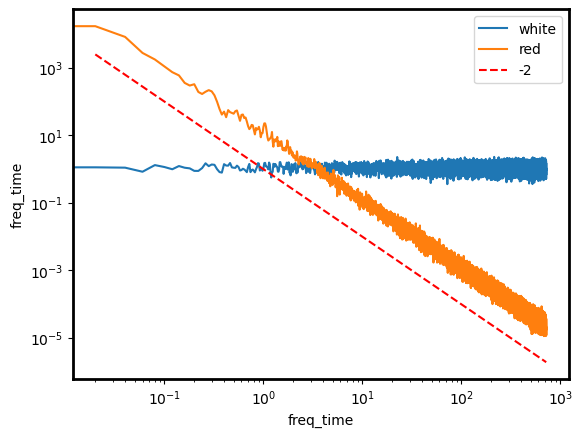

In [8]:
fig, ax =plt.subplots(1,1)
DS = {'white' : dsn, 'red':dsnr}
for l in DS :
    Ex = sigp.spectrum_welch(DS[l]['x_noise']+1j*DS[l]['y_noise'], T=50)[0]
    Ex = sum(negpos_spectra(Ex, freqkey = 'freq_time'))
    Ex.mean('draw').plot(label=l)
(Ex.freq_time**(-2)).plot(ax=ax, color='red', label = '-2', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

____________________
## Test noise rms after irregular_sampling

In [26]:
dsn_ir = irregular_time_sampling(dsn, offset_type="carthe_lops_5",)
dsnr_ir = irregular_time_sampling(dsnr, offset_type="carthe_lops_5",)

120424
59265


In [10]:
dsn_ir

<xarray.Dataset>
Dimensions:    (time: 11590, draw: 10)
Coordinates:
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * time       (time) datetime64[ns] 2000-01-01T00:04:59 ... 2000-02-19T23:58:57
Data variables:
    x          (time, draw) float64 -69.89 -7.703e+05 ... 1.825e+06 2.595e+06
    y          (time, draw) float64 -178.4 -4.004e+05 ... -1.651e+06 -1.412e+06
    time_days  (time, draw) float64 0.003461 0.003461 0.003461 ... 50.0 50.0
    x_noise    (time, draw) float64 7.148 -24.17 -0.08908 ... -9.366 3.59 17.1
    y_noise    (time, draw) float64 6.417 -16.36 14.63 ... -16.81 -22.08 -10.47

In [11]:
dsn_ir.x_noise.std('time').mean('draw'), dsnr_ir.x_noise.std('time').mean('draw')

(<xarray.DataArray 'x_noise' ()>
 array(19.94608659),
 <xarray.DataArray 'x_noise' ()>
 array(19.9396657))

In [12]:
dsn_ir.time.diff('time')

<xarray.DataArray 'time' (time: 11589)>
array([300000000000, 298000000000, 303000000000, ..., 301000000000,
       299000000000, 301000000000], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T00:09:59 ... 2000-02-19T23:58:57

____________________
## Test noise_irregular_sampling function

In [31]:
dsn_ir0 = noise_irregular_sampling(dst, t, position_noise,ntype='white_noise',update_vel_acc = True,
                                   offset_type="carthe_lops_5",dt=1 / 24,)
dsn_ir1 = noise_irregular_sampling(dst, t, position_noise,ntype='red_noise',update_vel_acc = True,
                                   offset_type="carthe_lops_5",dt=1 / 24,)

<xarray.DataArray 'draw' (draw: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
16934
<xarray.DataArray 'draw' (draw: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
<xarray.DataArray 'draw' (draw: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9
26644
<xarray.DataArray 'draw' (draw: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9


In [32]:
dsn_ir0

<xarray.Dataset>
Dimensions:    (time: 9470, draw: 10)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T00:05:35 ... 2000-02-19T23:59:50
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/15)
    x          (time, draw) float64 -87.17 -7.703e+05 ... 1.825e+06 2.595e+06
    y          (time, draw) float64 -198.6 -4.004e+05 ... -1.651e+06 -1.412e+06
    time_days  (time, draw) float64 0.003877 0.003877 0.003877 ... 50.0 50.0
    x_noise    (time, draw) float64 -8.729 -23.4 34.79 ... -22.76 -5.353 -16.09
    y_noise    (time, draw) float64 1.082 5.456 -19.64 ... 25.54 -3.663 34.29
    X          (time, draw) float64 216.9 8.682e+05 ... 2.461e+06 2.955e+06
    ...         ...
    ax         (time, draw) float64 -0.0004299 -0.0007656 ... 0.0001316
    ay         (time, draw) float64 0.0005246 -0.0004831 ... 0.001018 -0.0001813
    Axy        (time, draw) float64 0.0006782 0.0009053 ... 0.001042 0.000224
    au         (time, draw) float64 -0.0004076 -0.0007541 ... -0.0002083
    av         (time, draw) float64 0.0005 -0.0002818 ... -0.0007493 0.0005307
    Auv        (time, draw) float64 0.0006451 0.0008051 ... 0.0007964 0.0005701

In [21]:
dsn_ir0.time.diff('time')/pd.Timedelta('1s')

<xarray.DataArray 'time' (time: 8202)>
array([300., 300., 302., ..., 300., 290., 600.])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T00:10:00 ... 2000-02-19T23:58:15

In [22]:
dsn_ir0.x_noise.std('time').mean('draw').compute(), dsn_ir1.x_noise.std('time').mean('draw').compute()

(<xarray.DataArray 'x_noise' ()>
 array(19.99583814),
 <xarray.DataArray 'x_noise' ()>
 array(21.82365206))